In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import io
import pickle
import json

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *
from encoder import *
from Unet_pretrained import *
from DeeperUnet import *

In [2]:
# For this cell used same code from PyTorch notebook in assignment 2 of Stanford's CS231n Spring 2018 offering
preprocessData = False # To preprocess data set this to True
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    dtype = torch.float32

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [3]:
# For this cell, code belongs to [1]. Minor changes made to accomodate to our use 
# (Using PyTorch instead of Keras/tensorflow)
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
PATH = './stage1_train/'
epsilon = 1e-12 #For numerical stability

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1
random.seed = seed
np.random.seed = seed

In [3]:
# Opening up json file that contains preprocessed images
with open('processedData.json') as f:
    data = json.load(f)

X_train = np.array(data['X_train'])
Y_train = np.array(data['Y_train'])
X_val = np.array(data['X_val'])
Y_val = np.array(data['Y_val'])
X_test = np.array(data['X_test'])
Y_test = np.array(data['Y_test'])

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


In [5]:
def showVisualComparisons(y, pred):
    y_reshaped = np.transpose(y, (1,2,0))
    pred_reshaped = np.transpose(pred, (1,2,0))
    imshow(np.squeeze(np.uint8(y_reshaped)))
    plt.show()
    imshow(np.squeeze(np.uint8(pred_reshaped)))
    plt.show()

In [6]:
def calculatePerformance(X_perf, Y_perf, model, mini_batch_size =  64, visual = False):
    D = 1
    for i in range(len(Y_perf.shape)):
        D *= Y_perf.shape[i]
    model.eval() #set model to evaluation mode
    numCorrect = 0
    num_batches = int(X_perf.shape[0]/mini_batch_size)
    num_remaining = X_perf.shape[0] - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :]).type(torch.cuda.FloatTensor)
            x = x.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5).type(preds.type())
            numCorrect += (preds==y).sum()
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :]).type(torch.cuda.FloatTensor)
        x = x.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5).type(preds.type())
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), X_perf.shape[0])
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
        numCorrect += (preds==y).sum()
    return float(numCorrect)/float(D)

In [7]:
def trainModel(model, x_train, y_train, optimizer, epochs = 1, mini_batch_size = 64, noVal = False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    T = 0
    num_batches = int(len(x_train)/mini_batch_size)
    num_remaining = len(x_train) - num_batches *mini_batch_size
    loss_history = []
    for e in range(epochs):
        for t in range(num_batches):
            rand_indices = np.random.choice(len(x_train), mini_batch_size)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, currLoss))
            if (num_remaining <= 0 and t == (num_batches -1)):
                percentCorrect = calculatePerformance(x_train, y_train, model)
                print('Train percent correct at epoch %d is %.4f' % (e, percentCorrect))
                if (noVal == False):
                    percentCorrect = calculatePerformance(X_val, Y_val, model)
                    print('Val percent correct at epoch %d is %.4f' % (e, percentCorrect))
            T +=1
        if num_remaining > 0:
            rand_indices = np.random.choice(len(x_train), num_remaining)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, num_batches, currLoss))
            percentCorrect = calculatePerformance(x_train, y_train, model)
            print('Train percent correct at epoch %d is %.4f' % (e, percentCorrect))
            if (noVal == False):
                percentCorrect = calculatePerformance(X_val, Y_val, model)
                print('Val percent correct at epoch %d is %.4f' % (e, percentCorrect))
            T +=1
    return calculatePerformance(x_train, y_train, model),loss_history

In [8]:
x_train = X_train[:50,:,:,:]
y_train = Y_train[:50, :,:,:]
print_every = 1
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for lr in lrs:
    model = DeeperUNet()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf, lossHistory = trainModel(model, x_train, y_train, optimizer, epochs = 25, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = model
        lrUsed = lr

Epoch 0, Iteration 0, loss = 1.4764
Train percent correct at epoch 0 is 0.8268
Epoch 1, Iteration 0, loss = 4.7519
Train percent correct at epoch 1 is 0.8365
Epoch 2, Iteration 0, loss = 4.2569
Train percent correct at epoch 2 is 0.8365
Epoch 3, Iteration 0, loss = 4.1589
Train percent correct at epoch 3 is 0.8365
Epoch 4, Iteration 0, loss = 4.8139
Train percent correct at epoch 4 is 0.8365
Epoch 5, Iteration 0, loss = 5.1034
Train percent correct at epoch 5 is 0.8365
Epoch 6, Iteration 0, loss = 4.3632
Train percent correct at epoch 6 is 0.8365
Epoch 7, Iteration 0, loss = 4.8042
Train percent correct at epoch 7 is 0.8365
Epoch 8, Iteration 0, loss = 4.4322
Train percent correct at epoch 8 is 0.8365
Epoch 9, Iteration 0, loss = 4.6821
Train percent correct at epoch 9 is 0.8365
Epoch 10, Iteration 0, loss = 5.1149
Train percent correct at epoch 10 is 0.8365
Epoch 11, Iteration 0, loss = 4.3493
Train percent correct at epoch 11 is 0.8365
Epoch 12, Iteration 0, loss = 4.5556
Train perce

Epoch 3, Iteration 0, loss = 1.1080
Train percent correct at epoch 3 is 0.7114
Epoch 4, Iteration 0, loss = 1.0344
Train percent correct at epoch 4 is 0.7114
Epoch 5, Iteration 0, loss = 1.0081
Train percent correct at epoch 5 is 0.7114
Epoch 6, Iteration 0, loss = 1.1869
Train percent correct at epoch 6 is 0.7115
Epoch 7, Iteration 0, loss = 1.0679
Train percent correct at epoch 7 is 0.7115
Epoch 8, Iteration 0, loss = 1.0850
Train percent correct at epoch 8 is 0.7115
Epoch 9, Iteration 0, loss = 1.0487
Train percent correct at epoch 9 is 0.7114
Epoch 10, Iteration 0, loss = 1.1789
Train percent correct at epoch 10 is 0.7114
Epoch 11, Iteration 0, loss = 1.0503
Train percent correct at epoch 11 is 0.7114
Epoch 12, Iteration 0, loss = 1.1197
Train percent correct at epoch 12 is 0.7114
Epoch 13, Iteration 0, loss = 1.0279
Train percent correct at epoch 13 is 0.7114
Epoch 14, Iteration 0, loss = 1.1324
Train percent correct at epoch 14 is 0.7114
Epoch 15, Iteration 0, loss = 1.1419
Train

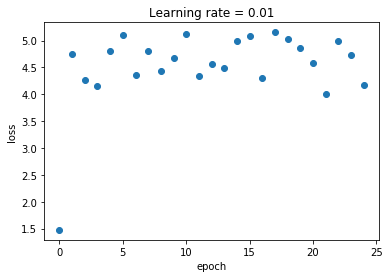

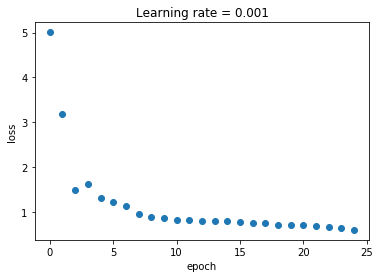

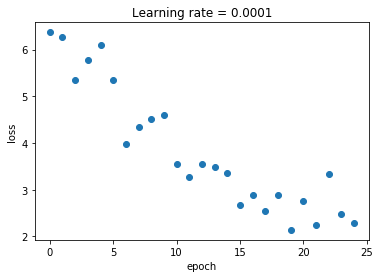

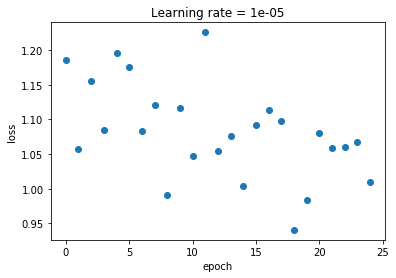

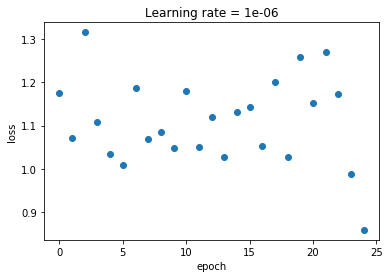

Lowest loss =  0.6038181781768799
Best lr =  0.001


In [9]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))
print('Best lr = ', str(lrUsed))

### Insight:
Looks like best training occurs at about 1e-3 so will explore randomly about this point.

In [38]:
x_train = X_train[:50,:,:,:]
y_train = Y_train[:50, :,:,:]
print_every = 1
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [0.0038283311267967024, 0.002539422889489561]
for i in range(4):
     lrs.append(.005*np.random.random())
for lr in lrs:
    model = DeeperUNet()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf, lossHistory = trainModel(model, x_train, y_train, optimizer, epochs = 30, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = model
        lrUsed = lr

Epoch 0, Iteration 0, loss = 2.8532
Train percent correct at epoch 0 is 0.8339
Epoch 1, Iteration 0, loss = 4.4894
Train percent correct at epoch 1 is 0.8344
Epoch 2, Iteration 0, loss = 4.9696
Train percent correct at epoch 2 is 0.8320
Epoch 3, Iteration 0, loss = 2.8800
Train percent correct at epoch 3 is 0.8191
Epoch 4, Iteration 0, loss = 1.9647
Train percent correct at epoch 4 is 0.7787
Epoch 5, Iteration 0, loss = 1.3893
Train percent correct at epoch 5 is 0.6452
Epoch 6, Iteration 0, loss = 0.8039
Train percent correct at epoch 6 is 0.4839
Epoch 7, Iteration 0, loss = 0.7230
Train percent correct at epoch 7 is 0.4203
Epoch 8, Iteration 0, loss = 0.7454
Train percent correct at epoch 8 is 0.4068
Epoch 9, Iteration 0, loss = 0.7291
Train percent correct at epoch 9 is 0.4073
Epoch 10, Iteration 0, loss = 0.7012
Train percent correct at epoch 10 is 0.4133
Epoch 11, Iteration 0, loss = 0.7061
Train percent correct at epoch 11 is 0.4636
Epoch 12, Iteration 0, loss = 0.6962
Train perce

Epoch 13, Iteration 0, loss = 0.5268
Train percent correct at epoch 13 is 0.8499
Epoch 14, Iteration 0, loss = 0.5290
Train percent correct at epoch 14 is 0.8516
Epoch 15, Iteration 0, loss = 0.5074
Train percent correct at epoch 15 is 0.8535
Epoch 16, Iteration 0, loss = 0.5050
Train percent correct at epoch 16 is 0.8554
Epoch 17, Iteration 0, loss = 0.4842
Train percent correct at epoch 17 is 0.8573
Epoch 18, Iteration 0, loss = 0.4894
Train percent correct at epoch 18 is 0.8589
Epoch 19, Iteration 0, loss = 0.4736
Train percent correct at epoch 19 is 0.8608
Epoch 20, Iteration 0, loss = 0.4644
Train percent correct at epoch 20 is 0.8627
Epoch 21, Iteration 0, loss = 0.4575
Train percent correct at epoch 21 is 0.8648
Epoch 22, Iteration 0, loss = 0.4630
Train percent correct at epoch 22 is 0.8671
Epoch 23, Iteration 0, loss = 0.4646
Train percent correct at epoch 23 is 0.8695
Epoch 24, Iteration 0, loss = 0.4342
Train percent correct at epoch 24 is 0.8721
Epoch 25, Iteration 0, loss 

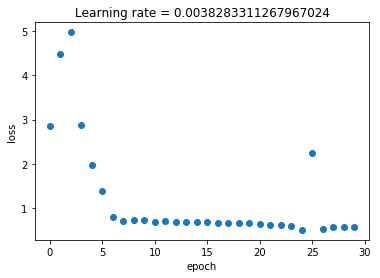

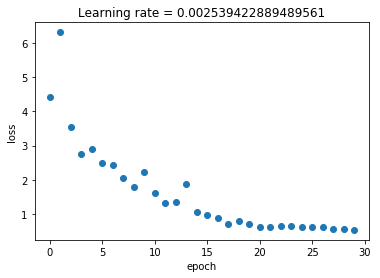

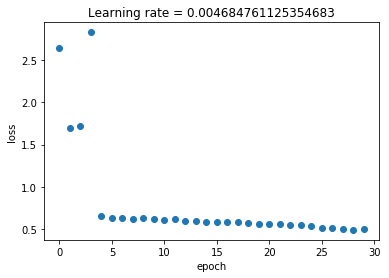

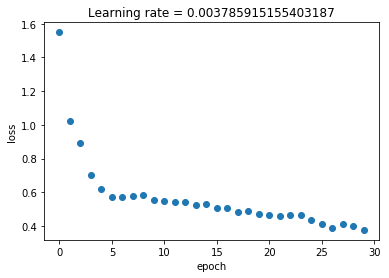

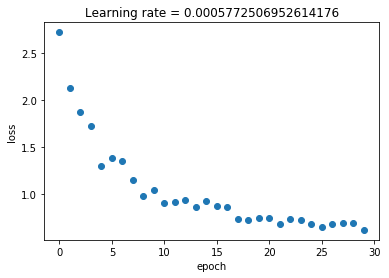

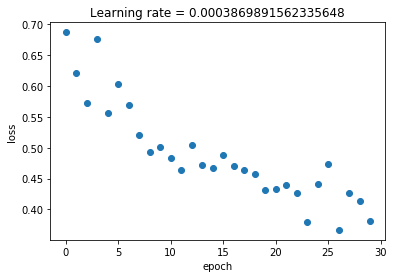

Lowest loss =  0.37628135085105896
Best lr =  0.003785915155403187


In [39]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))
print('Best lr = ', str(lrUsed))

Epoch 0, Iteration 0, loss = 11.0414
Epoch 0, Iteration 1, loss = 3.0531
Epoch 0, Iteration 2, loss = 0.9716
Epoch 0, Iteration 3, loss = 0.8997
Epoch 0, Iteration 4, loss = 1.0435
Epoch 0, Iteration 5, loss = 3.5271
Epoch 0, Iteration 6, loss = 0.7073
Train percent correct at epoch 0 is 0.4310
Epoch 1, Iteration 0, loss = 0.7418
Epoch 1, Iteration 1, loss = 0.7090
Epoch 1, Iteration 2, loss = 0.6944
Epoch 1, Iteration 3, loss = 0.7004
Epoch 1, Iteration 4, loss = 0.7146
Epoch 1, Iteration 5, loss = 0.6937
Epoch 1, Iteration 6, loss = 0.6815
Train percent correct at epoch 1 is 0.4633
Epoch 2, Iteration 0, loss = 0.6735
Epoch 2, Iteration 1, loss = 0.6667
Epoch 2, Iteration 2, loss = 0.6535
Epoch 2, Iteration 3, loss = 0.6415
Epoch 2, Iteration 4, loss = 0.6163
Epoch 2, Iteration 5, loss = 0.5903
Epoch 2, Iteration 6, loss = 0.5524
Train percent correct at epoch 2 is 0.8432
Epoch 3, Iteration 0, loss = 0.5393
Epoch 3, Iteration 1, loss = 0.5537
Epoch 3, Iteration 2, loss = 0.4876
Epoch 

Epoch 27, Iteration 3, loss = 0.1242
Epoch 27, Iteration 4, loss = 0.1310
Epoch 27, Iteration 5, loss = 0.1400
Epoch 27, Iteration 6, loss = 0.0664
Train percent correct at epoch 27 is 0.9514
Epoch 28, Iteration 0, loss = 0.1250
Epoch 28, Iteration 1, loss = 0.1551
Epoch 28, Iteration 2, loss = 0.1094
Epoch 28, Iteration 3, loss = 0.1240
Epoch 28, Iteration 4, loss = 0.0972
Epoch 28, Iteration 5, loss = 0.1459
Epoch 28, Iteration 6, loss = 0.1156
Train percent correct at epoch 28 is 0.9509
Epoch 29, Iteration 0, loss = 0.1314
Epoch 29, Iteration 1, loss = 0.1201
Epoch 29, Iteration 2, loss = 0.1110
Epoch 29, Iteration 3, loss = 0.1089
Epoch 29, Iteration 4, loss = 0.1239
Epoch 29, Iteration 5, loss = 0.1380
Epoch 29, Iteration 6, loss = 0.1298
Train percent correct at epoch 29 is 0.9519
Epoch 30, Iteration 0, loss = 0.1051
Epoch 30, Iteration 1, loss = 0.1184
Epoch 30, Iteration 2, loss = 0.1316
Epoch 30, Iteration 3, loss = 0.1126
Epoch 30, Iteration 4, loss = 0.0936
Epoch 30, Iterati

Epoch 54, Iteration 4, loss = 0.0927
Epoch 54, Iteration 5, loss = 0.1115
Epoch 54, Iteration 6, loss = 0.1338
Train percent correct at epoch 54 is 0.9641
Epoch 55, Iteration 0, loss = 0.1087
Epoch 55, Iteration 1, loss = 0.0942
Epoch 55, Iteration 2, loss = 0.1214
Epoch 55, Iteration 3, loss = 0.0818
Epoch 55, Iteration 4, loss = 0.0951
Epoch 55, Iteration 5, loss = 0.0805
Epoch 55, Iteration 6, loss = 0.1181
Train percent correct at epoch 55 is 0.9651
Epoch 56, Iteration 0, loss = 0.0829
Epoch 56, Iteration 1, loss = 0.0999
Epoch 56, Iteration 2, loss = 0.0997
Epoch 56, Iteration 3, loss = 0.0811
Epoch 56, Iteration 4, loss = 0.1089
Epoch 56, Iteration 5, loss = 0.0754
Epoch 56, Iteration 6, loss = 0.0641
Train percent correct at epoch 56 is 0.9652
Epoch 57, Iteration 0, loss = 0.0926
Epoch 57, Iteration 1, loss = 0.0974
Epoch 57, Iteration 2, loss = 0.0899
Epoch 57, Iteration 3, loss = 0.0769
Epoch 57, Iteration 4, loss = 0.1163
Epoch 57, Iteration 5, loss = 0.0987
Epoch 57, Iterati

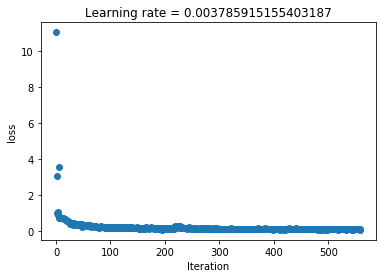

In [40]:
model = DeeperUNet()
optimizer = optim.Adam(model.parameters(), lr = lrUsed)
modelPerf, lossHistory = trainModel(model, X_train, Y_train, optimizer, epochs = 80, noVal = True)
plt.plot((np.arange(len(lossHistory))),lossHistory, 'o')
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Learning rate = '+ str(lrUsed))
plt.show()

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


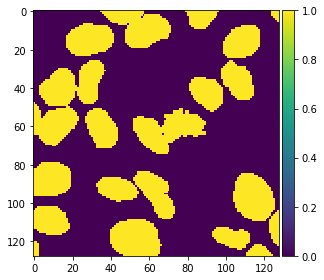

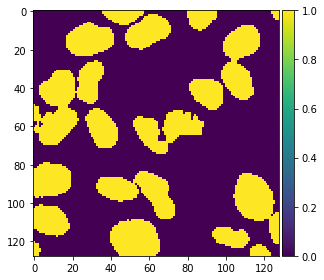

Percentage correct on train set =  0.9686496411983053
Percentage correct on val set =  0.961387064919543


In [41]:
# Let us visualize how different our predicted masks are
print('Percentage correct on train set = ', calculatePerformance(X_train, Y_train, model, visual = True))
print('Percentage correct on val set = ', calculatePerformance(X_val, Y_val, model, visual = False))
torch.save(model, 'deeperUNet')

Epoch 0, Iteration 0, loss = 0.0846
Epoch 0, Iteration 1, loss = 0.4306
Epoch 0, Iteration 2, loss = 0.1189
Epoch 0, Iteration 3, loss = 0.3599
Epoch 0, Iteration 4, loss = 0.1596
Epoch 0, Iteration 5, loss = 0.1725
Epoch 0, Iteration 6, loss = 0.1384
Train percent correct at epoch 0 is 0.9510
Epoch 1, Iteration 0, loss = 0.1425
Epoch 1, Iteration 1, loss = 0.1547
Epoch 1, Iteration 2, loss = 0.1367
Epoch 1, Iteration 3, loss = 0.1660
Epoch 1, Iteration 4, loss = 0.1535
Epoch 1, Iteration 5, loss = 0.1062
Epoch 1, Iteration 6, loss = 0.1314
Train percent correct at epoch 1 is 0.9501
Epoch 2, Iteration 0, loss = 0.1172
Epoch 2, Iteration 1, loss = 0.1106
Epoch 2, Iteration 2, loss = 0.1558
Epoch 2, Iteration 3, loss = 0.1309
Epoch 2, Iteration 4, loss = 0.1346
Epoch 2, Iteration 5, loss = 0.1254
Epoch 2, Iteration 6, loss = 0.1318
Train percent correct at epoch 2 is 0.9535
Epoch 3, Iteration 0, loss = 0.1486
Epoch 3, Iteration 1, loss = 0.1083
Epoch 3, Iteration 2, loss = 0.1054
Epoch 3

Epoch 27, Iteration 3, loss = 0.0890
Epoch 27, Iteration 4, loss = 0.0771
Epoch 27, Iteration 5, loss = 0.0751
Epoch 27, Iteration 6, loss = 0.0778
Train percent correct at epoch 27 is 0.9673
Epoch 28, Iteration 0, loss = 0.0714
Epoch 28, Iteration 1, loss = 0.0792
Epoch 28, Iteration 2, loss = 0.0496
Epoch 28, Iteration 3, loss = 0.0735
Epoch 28, Iteration 4, loss = 0.0861
Epoch 28, Iteration 5, loss = 0.0816
Epoch 28, Iteration 6, loss = 0.0765
Train percent correct at epoch 28 is 0.9708
Epoch 29, Iteration 0, loss = 0.0958
Epoch 29, Iteration 1, loss = 0.0817
Epoch 29, Iteration 2, loss = 0.0768
Epoch 29, Iteration 3, loss = 0.0921
Epoch 29, Iteration 4, loss = 0.0689
Epoch 29, Iteration 5, loss = 0.0656
Epoch 29, Iteration 6, loss = 0.0933
Train percent correct at epoch 29 is 0.9708
Epoch 30, Iteration 0, loss = 0.0774
Epoch 30, Iteration 1, loss = 0.0688
Epoch 30, Iteration 2, loss = 0.0629
Epoch 30, Iteration 3, loss = 0.0760
Epoch 30, Iteration 4, loss = 0.0866
Epoch 30, Iterati

Epoch 54, Iteration 4, loss = 0.0616
Epoch 54, Iteration 5, loss = 0.0718
Epoch 54, Iteration 6, loss = 0.0535
Train percent correct at epoch 54 is 0.9727
Epoch 55, Iteration 0, loss = 0.0834
Epoch 55, Iteration 1, loss = 0.0539
Epoch 55, Iteration 2, loss = 0.0892
Epoch 55, Iteration 3, loss = 0.0760
Epoch 55, Iteration 4, loss = 0.0583
Epoch 55, Iteration 5, loss = 0.0636
Epoch 55, Iteration 6, loss = 0.0860
Train percent correct at epoch 55 is 0.9728
Epoch 56, Iteration 0, loss = 0.0718
Epoch 56, Iteration 1, loss = 0.0698
Epoch 56, Iteration 2, loss = 0.0842
Epoch 56, Iteration 3, loss = 0.0702
Epoch 56, Iteration 4, loss = 0.0675
Epoch 56, Iteration 5, loss = 0.0599
Epoch 56, Iteration 6, loss = 0.0939
Train percent correct at epoch 56 is 0.9724
Epoch 57, Iteration 0, loss = 0.0711
Epoch 57, Iteration 1, loss = 0.0747
Epoch 57, Iteration 2, loss = 0.0705
Epoch 57, Iteration 3, loss = 0.0697
Epoch 57, Iteration 4, loss = 0.0792
Epoch 57, Iteration 5, loss = 0.0776
Epoch 57, Iterati

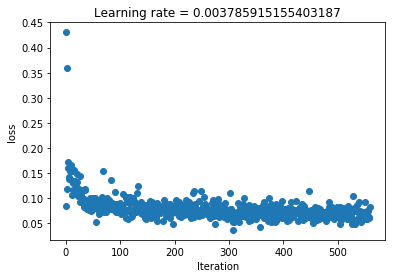

In [43]:
# Let's train for 40 more epochs since all other models were trained for 120 epochs
model = torch.load('deeperUNet')
optimizer = optim.Adam(model.parameters(), lr = lrUsed)
modelPerf, lossHistory = trainModel(model, X_train, Y_train, optimizer, epochs = 80, noVal = True)
plt.plot((np.arange(len(lossHistory))),lossHistory, 'o')
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Learning rate = '+ str(lrUsed))
plt.show()
torch.save(model, 'bestDeepUNet')

In [46]:
modelNames = ['bestDeepUNet','bestTransferUNet','bestGroupNormUNet','bestLayerNormUNet', 'bestBaselineUNet']
for modelName in modelNames:
    currModel = torch.load(modelName)
    print(modelName, ' percent correct on train set = ', calculatePerformance(X_train, Y_train, currModel, visual = False))
    print(modelName, ' percent correct on val set = ', calculatePerformance(X_val, Y_val, currModel, visual = False))
    print(modelName, ' percent correct on test set = ', calculatePerformance(X_test, Y_test, currModel, visual = False))

bestDeepUNet  percent correct on train set =  0.9734424192513993
bestDeepUNet  percent correct on val set =  0.9662553018598414
bestDeepUNet  percent correct on test set =  0.9725264364214086
bestTransferUNet  percent correct on train set =  0.9741531296155939
bestTransferUNet  percent correct on val set =  0.9652245364972015
bestTransferUNet  percent correct on test set =  0.9735991065181903
bestGroupNormUNet  percent correct on train set =  0.9719236762962531
bestGroupNormUNet  percent correct on val set =  0.9596398197003265
bestGroupNormUNet  percent correct on test set =  0.9726457738164646
bestLayerNormUNet  percent correct on train set =  0.9882000216204135
bestLayerNormUNet  percent correct on val set =  0.9510866990729944
bestLayerNormUNet  percent correct on test set =  0.96240234375
bestBaselineUNet  percent correct on train set =  0.9731689756782493
bestBaselineUNet  percent correct on val set =  0.9645909551364272
bestBaselineUNet  percent correct on test set =  0.97154213

# References
[1] Amdal-Saevik, K. (2018). Keras U-Net starter - LB 0.277. 
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/code

[2] Ho, D. J., Fu, C., Salama, P., Dunn, K. W., and Delp, E. J. (2017, July). Nuclei Segmentation of Fluorescence Microscopy Images Using Three Dimensional Convolutional Neural Networks. In Computer Vision and Pattern Recognition Workshops (CVPRW), 2017 IEEE Conference on (pp. 834-842). IEEE.

[3] Kakade, A., and Dumbali, J. (2018, February). Identification of nerve in ultrasound images using U-net architecture. In 2018 International Conference on Communication information and Computing Technology (ICCICT) (pp. 1-6). IEEE.

[4] Li, X., Chen, H., Qi, X., Dou, Q., Fu, C. W., and Heng, P. A. (2017). H-DenseUNet: Hybrid densely connected UNet for liver and liver tumor segmentation from CT volumes. arXiv preprint arXiv:1709.07330.

[5] Ronneberger, O., Fischer, P., and Brox, T. 
(2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[6] Pearce, C. Convolutional (2017). Neural Networks and the Analysis of Cancer Imagery.

[7] Imagenet. https://patrykchrabaszcz.github.io/Imagenet32/